In [71]:
# enable automatic reloading of imported modules.
%reload_ext autoreload
%autoreload 2

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


[0, 2, 0]
[0, 2, 0]


In [72]:
from src.master import MasterProblem
from src.slave import SlaveProblem
from src.slave_he import GeneticAlgorithm
from src.ISlave import *
from pulp import *
import numpy as np
import csv
import time

 This code combines the genetic algorithm and the PuLP solver to solve an optimization problem related to axis cutting, with the goal of finding the optimal number of axes to cut. The genetic algorithm is used to generate patterns, and the PuLP solver is used to solve the master problem and obtain dual values for updating the patterns.

In [73]:
# Param Definition

# Lettura delle istanze
max_axis_length = 0
axis_lengths = []
axis_demands = []

max_length = 25
num_items =12
file_name = f"data/input_data_{max_length}_{num_items}.csv"

with open(file_name, newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    max_axis_length, *data = [list(map(int, row)) for row in reader]
    
max_axis_length = max_axis_length[0]
axis_lengths = [row[0] for row in data]
axis_demands = [row[1] for row in data]
num_axes = len(axis_lengths)

print("Max Axis Length: %s" % max_axis_length)
print("Axis Lengths: %s" % axis_lengths)
print("Axis Demands: %s\n" % axis_demands)
print("Axis types: %s\n" % num_axes)


Max Axis Length: 25
Axis Lengths: [13, 16, 8, 18, 11, 15, 19, 17, 22, 9, 7, 21]
Axis Demands: [17, 89, 12, 43, 79, 39, 19, 57, 68, 64, 29, 93]

Axis types: 12



Il codice fornito implementa un approccio di risoluzione iterativa per un problema di ottimizzazione. Viene generata una soluzione iniziale in modo greedy, utilizzando una strategia che associa un asse per ciascuna richiesta con la lunghezza corrispondente. 

Successivamente, viene creato un oggetto `MasterProblem` con i parametri e i pattern iniziali forniti. Il problema viene risolto inizialmente in modalità rilassata.

Il codice entra in un ciclo while che continua fino a quando il problema non è più in modalità rilassata. Ad ogni iterazione, il `masterProblem` viene risolto e vengono controllate le variabili duali ottenute per verificare eventuali cambiamenti. Se le variabili duali rimangono invariate, viene decrementato un contatore per le iterazioni consecutive senza cambiamenti ( di variabili duali) . Altrimenti, il contatore viene ripristinato a 100. Se ci sono ancora iterazioni consecutive senza cambiamenti, viene generato un nuovo pattern utilizzando il metodo `startSlave` del `masterProblem` e viene aggiunto al problema se esiste. 

Una volta che non ci sono più iterazioni consecutive senza cambiamenti, viene chiamato il metodo `setRelaxed` per impostare il problema in modalità non rilassata ( quindi riportandolo ad un PLI ). Il problema viene risolto nuovamente in questa modalità e il flag rilassato viene impostato su False, terminando il ciclo while.

Viene calcolato e stampato il tempo di calcolo, il numero ottimale di assi da tagliare e il numero di iterazioni. Se `show_results` è True, vengono 



In [74]:

def runColumnGeneration(max_axis_length, axis_lengths, axis_demands, slaveType=SlaveProblem, debugMode=False):
    # Generazione dei file .lp
    SlaveProblem.it = 0
    MasterProblem.it = 0
    
    start_time = time.time()

    # Initial solution (greedy):
    # - Use one axes for each demand of that axes length
    # - Start with a poor solution and expect the total required axes to decrease
    patterns = []
    for i in range(num_axes):
        pattern = np.zeros(num_axes)
        pattern[i] = 1
        patterns.append(pattern)

    masterProblem = MasterProblem(max_axis_length, axis_lengths, axis_demands, patterns, slaveType,writeLP=True)

    relaxed = True
    iteration = 0
    max_iterations = 1000
    consecutive_unchanged_duals = 15
    old_duals = []

    while relaxed and iteration < max_iterations:
        duals = masterProblem.solve()
        status = masterProblem.getStatus()
        if(status =='Infeasible'):
            print("The problem is Infeasible, stopping now")
            return
            

        if old_duals == duals:
            consecutive_unchanged_duals -= 1
        else:
            consecutive_unchanged_duals = 15
        if consecutive_unchanged_duals > 0:
            newPattern = masterProblem.startSlave(duals)
           
            if newPattern:
                masterProblem.addPattern(newPattern)
                if(debugMode):
                    print("New duals", duals)
                    print("New pattern added", newPattern)
        else:
            masterProblem.setRelaxed(False)
            masterProblem.solve()
            relaxed = False

        old_duals = duals
        iteration += 1

    end_time = time.time()
    seconds = end_time - start_time


    optimal = masterProblem.getComputedOptimal()
    print("Optimal: %s axes to cut" % optimal)
    print("Found in %s iterations" % iteration)
    print("Computational time: %s seconds" % seconds)
    if(debugMode):
        for pattern in masterProblem.getUsedPatterns():
            print("%s used %s times" % (pattern[1], pattern[0]))
    return  masterProblem.getUsedPatterns()


In questo primo TEST verrà eseguito  `startSlave` su una istanza di 'GeneticAlgorithm'
L'algoritmo genetico e il solver PuLP sono quindi utilizzati per risolvere problema di ottimizzazione legato al taglio degli assi, con l'obiettivo di trovare il numero ottimale di assi da tagliare. L'algoritmo genetico viene utilizzato per generare i pattern, mentre il solver PuLP viene utilizzato per risolvere il problema principale e ottenere i valori duali per l'aggiornamento dei pattern.

In [75]:
genPatterns = runColumnGeneration(max_axis_length, axis_lengths, axis_demands, GeneticAlgorithm,debugMode=True,)


New duals [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
New pattern added [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0]
New duals [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.33333333, 1.0]
New pattern added [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0]
New duals [1.0, 1.0, 0.33333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.33333333, 1.0]
New pattern added [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0]
New duals [1.0, 1.0, 0.33333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.0, 1.0]
New pattern added [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0]
New duals [1.0, 1.0, 0.33333333, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.5, 0.0, 1.0]
New pattern added [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
New duals [0.5, 1.0, 0.33333333, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.5, 0.0, 1.0]
New pattern added [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]
New duals [0.5, 1.0, 0.33333333, 1.0, 0.5, 0.66666667, 1.0, 1.0, 1.0, 0.33333333, 0.33333333, 1.0]
New pattern added [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
New duals [0.5, 1.0, 0.33333333, 1.0, 0.5, 0.5, 

In questo TEST verrà eseguito  `startSlave` su una istanza di 'Pulp Solver CBC ' (COIN-OR branch and cut)


In [76]:
cbcPatterns = runColumnGeneration(max_axis_length, axis_lengths, axis_demands, SlaveProblem,debugMode=True)


New duals [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
New pattern added [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0]
New duals [1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0]
New pattern added [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0]
New duals [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.0, 1.0]
New pattern added [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0]
New duals [1.0, 1.0, 0.33333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.0, 1.0]
New pattern added [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0]
New duals [1.0, 1.0, 0.33333333, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.5, 0.0, 1.0]
New pattern added [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
New duals [0.66666667, 1.0, 0.33333333, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.33333333, 0.33333333, 1.0]
New pattern added [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]
New duals [0.5, 1.0, 0.33333333, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.5, 0.0, 1.0]
New pattern added [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]
New duals [0.66666667, 1.0, 0.33333333, 1.0, 0.5, 0.66666667, 1.0, 1.

Formulazione 'PLI' del problema 

In [77]:
# Creazione del problema
prob = LpProblem("1D-Stock-Cut", LpMinimize)

# Variabili di decisione
pattern_vars = LpVariable.dicts("Pattern", range(len(axis_lengths)), 0, None, LpInteger)

# Funzione obiettivo
prob += lpSum(pattern_vars)

# Vincoli
for i in range(len(axis_lengths)):
    prob += axis_lengths[i] * pattern_vars[i] >= max_axis_length

for i in range(len(axis_lengths)):
    prob += pattern_vars[i] >= axis_demands[i]

# Risoluzione del problema
prob.solve()

# Stampa della soluzione
print("Status:", LpStatus[prob.status])
print("Optimal number of axes to cut:", value(prob.objective))

# Stampa dei pattern utilizzati
used_patterns = []
for i in range(len(axis_lengths)):
    if value(pattern_vars[i]) > 0:
        used_patterns.append((value(pattern_vars[i]), i))

print("Used patterns:")
for pattern in used_patterns:
    print("Pattern", pattern[1], "used", pattern[0], "times")

prob.writeLP('models/pli/prob.lp')


Status: Optimal
Optimal number of axes to cut: 609.0
Used patterns:
Pattern 0 used 17.0 times
Pattern 1 used 89.0 times
Pattern 2 used 12.0 times
Pattern 3 used 43.0 times
Pattern 4 used 79.0 times
Pattern 5 used 39.0 times
Pattern 6 used 19.0 times
Pattern 7 used 57.0 times
Pattern 8 used 68.0 times
Pattern 9 used 64.0 times
Pattern 10 used 29.0 times
Pattern 11 used 93.0 times


[Pattern_0,
 Pattern_1,
 Pattern_10,
 Pattern_11,
 Pattern_2,
 Pattern_3,
 Pattern_4,
 Pattern_5,
 Pattern_6,
 Pattern_7,
 Pattern_8,
 Pattern_9]

Total patterns cbcPatterns 12
Total patterns genPatterns 12
Common 9


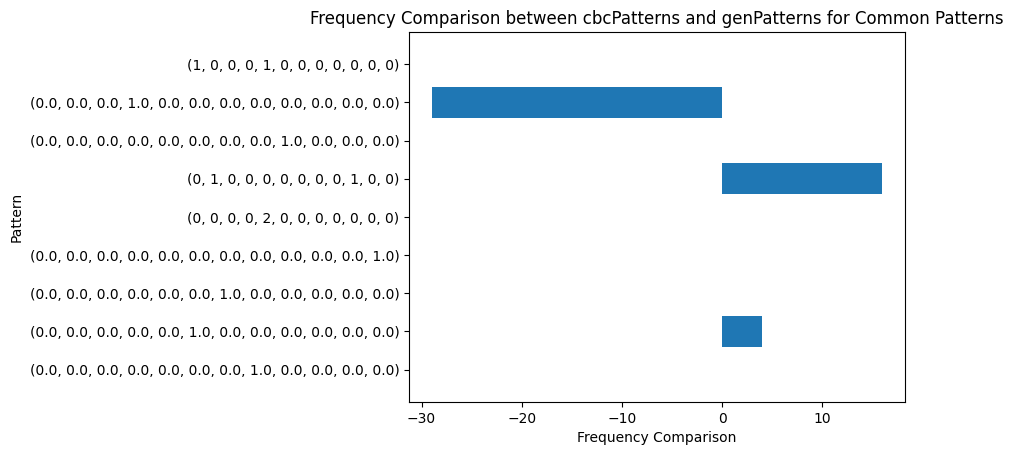

In [78]:
import matplotlib.pyplot as plt

def plotData(patterns_model1,patterns_model2):

    common_patterns = set([tuple(pattern) for (_, pattern) in patterns_model1]).intersection(set([tuple(pattern) for    (_, pattern) in patterns_model2]))
    print("Common",len(common_patterns))

    freq_model1 = {tuple(pattern): freq for (freq, pattern) in patterns_model1}
    freq_model2 = {tuple(pattern): freq for (freq, pattern) in patterns_model2}

    pattern_labels = [str(pattern) for pattern in common_patterns]
    freq_comparison = [freq_model2[pattern] - freq_model1[pattern] for pattern in common_patterns]

    plt.barh(pattern_labels, freq_comparison)
    plt.xlabel('Frequency Comparison')
    plt.ylabel('Pattern')
    plt.title('Frequency Comparison between cbcPatterns and genPatterns for Common Patterns')
    plt.show()
print("Total patterns cbcPatterns", len(cbcPatterns))
print("Total patterns genPatterns", len(genPatterns))

plotData(cbcPatterns,genPatterns)
